# Analysis of the ENERTALK Dataset

In this Jupyter Notebook we present the ENERTALK dataset. The ENERTALK dataset provides detailed aggregate and per-appliance measurements sampled at 15 Hz from 22 houses, a comprehensive dataset for energy consumption analysis in residential buildings.

**Note**: While this analysis focuses on house 5, the Jupyter notebook is designed to be adaptable and reusable for other houses in the dataset. 

**Additional Note**: There is a different notebook titled "functions" in the same repository. This notebook contains all the utility functions that are used and called in this ENERTALK analysis notebook.

## Dataset Structure and Columns
The ENERTALK dataset is organized in zip files named `enertalk-dataset-{house_number}`, containing a directory for each house. Each house directory includes subdirectories with Parquet files for daily aggregate and appliance-level data. These subdirectories are named using the date convention (e.g., “20170131” for January 31, 2017). Inside, the Parquet files are named following the pattern “_.parquet.gzip” (e.g., “01_fridge.parquet.gzip”). Each file contains three columns: `timestamp`, `active_power`, and `reactive_power`.

## Content Overview

### General Dataset Analysis
- Missing Days
- Missing Values per Column
- Appliance File Presence by Day
  - Heatmap

### Detailed Analysis for Day 2016-09-13
- Line Plot of Active Power Over Time per Appliance
- Summary Statistics
- Boxplot for Active and Reactive Power per Appliance
- Histograms for Active and Reactive Power per Appliance
- Measurements Gap Occurrence by Threshold and Appliance

### Data Aggregation
- By Hour
  - Barplots for Active Power per Appliance
- By Minute
  - Line Plot for Active Power per Appliance Over 7 Days

### Power Consumption Peak Hours
- Peak Hours Heatmap


#### Preparation

In [ ]:
# helper functions
def get_app_name_from_fname(fname):
    appliance_name = fname.split('_')[1].split('.')[0]
    return appliance_name


def clean_name(appliance_name):
    return appliance_name.replace('-', ' ').title()


def get_one_day(day_path):
    target_file_names = [f for f in os.listdir(day_path)]
    target_sample = [pd.read_parquet(day_path + '/' + f_name) for f_name in target_file_names]
    
    for sample_index in range(0, len(target_sample)):
        target_sample[sample_index]['timestamp'] = pd.to_datetime(target_sample[sample_index]['timestamp'], unit = 'ms')
        target_sample[sample_index].set_index('timestamp', inplace=True)
        target_sample[sample_index]['appliance_name'] = target_file_names[sample_index].split('_', 1)[1].split('.',1)[0] #adding new column for app name
    
    target_sample = pd.concat(target_sample)
    print(set(target_sample['appliance_name']))
    
    return(target_sample)


def get_summary_statistics(day_path):
    day_data = get_one_day(day_path)
    summary_stats = day_data.groupby('appliance_name').describe()
    summary_stats_transposed = summary_stats.transpose()
    return summary_stats_transposed


def count_gaps(df, thresholds):
    gap_counts = {threshold: [] for threshold in thresholds}
    df['time_diff'] = df.index.to_series().diff().dt.total_seconds().fillna(0)
    
    for appliance in df['appliance_name'].unique():
        appliance_data = df[df['appliance_name'] == appliance]
        
        for threshold in thresholds:
            gap_count = np.sum(appliance_data['time_diff'] > threshold)
            gap_counts[threshold].append(gap_count)
   
    return gap_counts


def format_threshold(seconds):
    if seconds >= 3600:
        return f"{seconds // 3600}h"
    elif seconds >= 60:
        return f"{seconds // 60}m"
    else:
        return f"{seconds}s"


def aggregate_by_minute(target_data):
    target_data['timestamp'] = pd.to_datetime(target_data['timestamp'], unit='ms')
    target_data['minute'] = target_data['timestamp'].dt.minute
    target_data_agg = target_data.groupby(['minute', 'appliance_name']).agg({'active_power': 'mean', 'reactive_power': 'mean'})
    return target_data_agg


def aggregate_by_hour(target_data):
    target_data['timestamp'] = pd.to_datetime(target_data['timestamp'], unit='ms')
    target_data['hour'] = target_data['timestamp'].dt.hour
    target_data_agg = target_data.groupby(['hour', 'appliance_name']).agg({'active_power': 'mean', 'reactive_power': 'mean'})
    return target_data_agg

In [85]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from matplotlib.colors import LogNorm

In [86]:
base_directory = '../../files/ENERTALK/'
house_number = '05' 
house_path = os.path.join(base_directory, house_number) 

## Missing Days

In [87]:
#days where no data was collected
dates_present = [d for d in os.listdir(house_path) if os.path.isdir(os.path.join(house_path, d))]
dates_present = [datetime.strptime(date, "%Y%m%d") for date in dates_present]
dates_present.sort()

start_date = dates_present[0]
end_date = dates_present[-1]
all_dates = {start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)}

missing_dates = all_dates - set(dates_present)
missing_dates = [date.strftime("%Y-%m-%d") for date in missing_dates]

print("Missing dates:", missing_dates)

Missing dates: ['2016-09-22']


## Missing Values per Column

In [46]:
missing_values_count = {}
dates = sorted(os.listdir(house_path))
for date in dates:
    day_path = os.path.join(house_path, date)
    if os.path.isdir(day_path):
        files = os.listdir(day_path)
        for file in files:
            file_path = os.path.join(day_path, file)
            try:
                df = pd.read_parquet(file_path)
                for column in df.columns:
                    if column not in missing_values_count:
                        missing_values_count[column] = 0
                    missing_values_count[column] += df[column].isna().sum()
            except Exception as e:
                print(f"Error processing file {file}: {e}")
print("Total missing values count per column:")
for column, count in missing_values_count.items():
    print(f"{column}: {count}")

Total missing values count per column:
active_power: 0
reactive_power: 0
timestamp: 0


## Appliance Data Presence by Day

In [11]:
#checking which appliance data is available for each day
#Identify all appliances present for one house :
appliances = []
dates = sorted(os.listdir(house_path))
for date in dates:
    day_path = os.path.join(house_path, date)
    if os.path.isdir(day_path):
        files = os.listdir(day_path)
        for file in files:
            appliance_name = get_app_name_from_fname(file)
            appliance_name = clean_name(appliance_name)
            if appliance_name not in appliances:
                appliances.append(appliance_name)
                
#create a binary matrix showing the availability of data for each appliance on each date.
presence_data = pd.DataFrame(index=appliances, columns=dates).fillna(0)
for date in dates:
    day_path = os.path.join(house_path, date)
    if os.path.isdir(day_path):
        files = os.listdir(day_path)
        for file in files:
            appliance_name = get_app_name_from_fname(file)
            appliance_name = clean_name(appliance_name)
            presence_data.at[appliance_name, date] = 1 

In [48]:
presence_data.shape

(6, 58)

## Heatmap

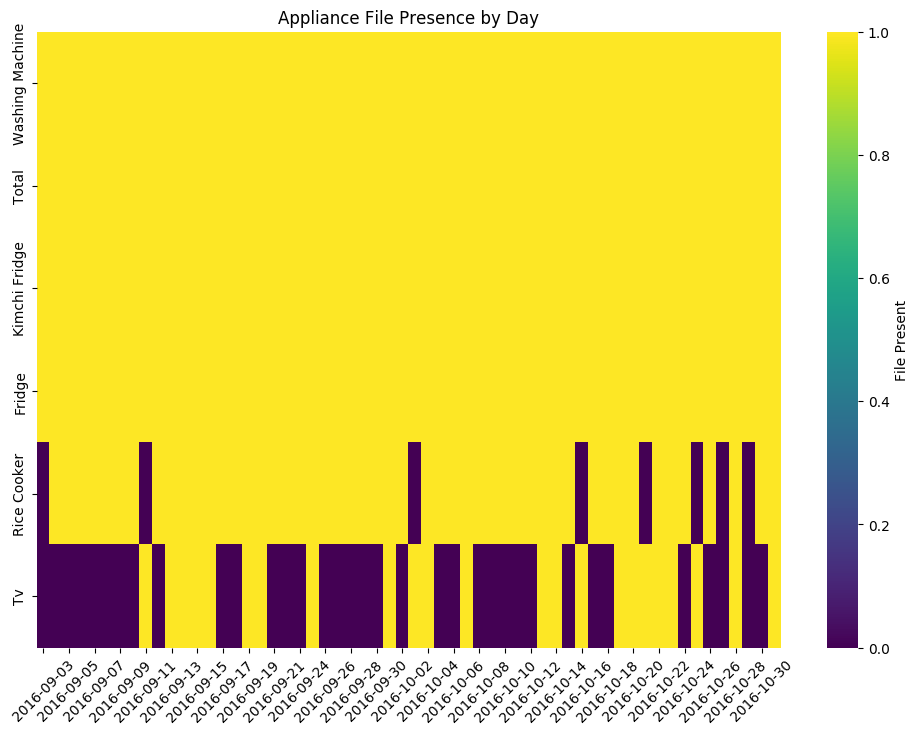

In [49]:
plt.figure(figsize=(12, 8))
presence_data.columns = [datetime.strptime(date, "%Y%m%d").strftime("%Y-%m-%d") for date in presence_data.columns]
sns.heatmap(presence_data, cmap="viridis", cbar_kws={'label': 'File Present'})
plt.title("Appliance File Presence by Day")
plt.xticks(rotation=45)
plt.show()

## Analysis for Day 2016- 09 -13

In [15]:
day_data= get_one_day('../../files/ENERTALK/05/20160913')

{'rice-cooker', 'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}


In [49]:
day_data

active_power  reactive_power   appliance_name
timestamp                                                                   
2016-09-13 00:00:00.289999872          0.12            1.28  washing-machine
2016-09-13 00:00:00.356000000          0.03            1.26  washing-machine
2016-09-13 00:00:00.423000064          0.04            1.26  washing-machine
2016-09-13 00:00:00.489999872          0.05            1.31  washing-machine
2016-09-13 00:00:00.556000000          0.04            1.29  washing-machine
...                                     ...             ...              ...
2016-09-13 23:59:56.006000128          1.25           -6.78           fridge
2016-09-13 23:59:56.072999936          1.27           -6.79           fridge
2016-09-13 23:59:56.140000000          1.50           -6.89           fridge
2016-09-13 23:59:56.206000128          1.24           -6.92           fridge
2016-09-13 23:59:56.272999936          1.43           -6.96           fridge

[7169790 rows x 3 columns]

## Line Plot of Active Power Over Time per Appliance

/home/rania/korea/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


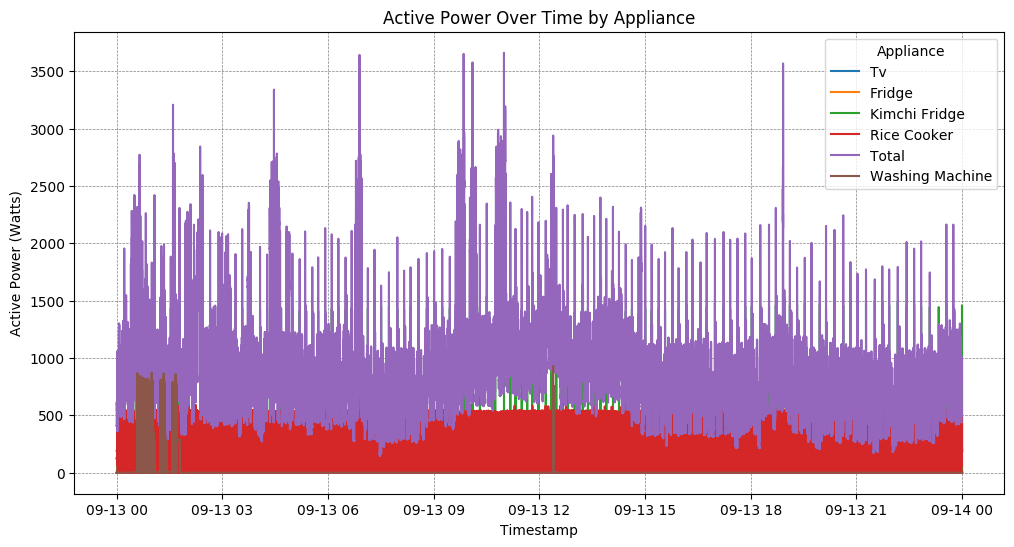

In [9]:
day_data= day_data.groupby('appliance_name')

plt.figure(figsize=(12, 6))

for appliance_name, group in day_data:
    clean_appliance_name = clean_name(appliance_name)
    plt.plot(group.index.to_numpy(), group['active_power'].to_numpy(), label=clean_appliance_name)

plt.xlabel('Timestamp')
plt.ylabel('Active Power (Watts)')
plt.title('Active Power Over Time by Appliance')
plt.legend(title='Appliance')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.show()


## Summary Statistics

In [58]:
summary_stats = get_summary_statistics('../../files/ENERTALK/05/20160913')
summary_stats

{'rice-cooker', 'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}


appliance_name                   TV        fridge  kimchi-fridge  \
active_power   count  841965.000000  1.258680e+06   1.275930e+06   
               mean      134.246640  1.144759e+02   4.853401e+01   
               std        53.692825  3.423362e+01   7.852957e+01   
               min         0.000000  1.000000e-02   7.400000e-01   
               25%       137.810000  1.173200e+02   1.560000e+00   
               50%       150.500000  1.204700e+02   2.046000e+01   
               75%       161.710000  1.252400e+02   2.133000e+01   
               max       209.000000  2.593300e+02   1.492810e+03   
reactive_power count  841965.000000  1.258680e+06   1.275930e+06   
               mean      -32.517699 -3.299705e+00   3.327491e+01   
               std         6.292179  2.379368e+00   6.582211e+01   
               min       -47.730000 -3.627000e+01  -6.530000e+00   
               25%       -37.300000 -4.610000e+00  -1.320000e+00   
               50%       -33.790000 -2.850000e+00  -1.260000e+00   
               75%       -30.190000 -1.630000e+00  -1.150000e+00   
               max        -0.540000  2.380000e+00   7.055200e+02   

appliance_name         rice-cooker         total  washing-machine  
active_power   count  1.275045e+06  1.289430e+06     1.228740e+06  
               mean   3.692669e+01  7.124141e+02     7.535907e+00  
               std    6.923528e+01  3.853647e+02     5.642014e+01  
               min    1.120000e+00  1.485900e+02     0.000000e+00  
               25%    1.540000e+00  4.846600e+02     3.000000e-02  
               50%    1.600000e+00  6.386900e+02     7.000000e-02  
               75%    6.095000e+01  8.128800e+02     1.100000e-01  
               max    5.977200e+02  3.660470e+03     9.308600e+02  
reactive_power count  1.275045e+06  1.289430e+06     1.228740e+06  
               mean  -3.339302e+01 -4.806600e+01    -1.078959e+00  
               std    1.340976e+01  8.986175e+01     1.629806e+01  
               min   -1.468900e+02 -2.694900e+02    -2.749700e+02  
               25%   -3.210000e+01 -1.049200e+02     1.200000e+00  
               50%   -3.152000e+01 -7.516000e+01     1.250000e+00  
               75%   -3.102000e+01 -4.796000e+01     1.300000e+00  
               max   -2.876000e+01  2.216170e+03     7.420000e+00

In [59]:
active_power_stats = summary_stats.iloc[:8, :]
reactive_power_stats = summary_stats.iloc[8:, :].abs()

In [60]:
active_power_stats

appliance_name                 TV        fridge  kimchi-fridge   rice-cooker  \
active_power count  841965.000000  1.258680e+06   1.275930e+06  1.275045e+06   
             mean      134.246640  1.144759e+02   4.853401e+01  3.692669e+01   
             std        53.692825  3.423362e+01   7.852957e+01  6.923528e+01   
             min         0.000000  1.000000e-02   7.400000e-01  1.120000e+00   
             25%       137.810000  1.173200e+02   1.560000e+00  1.540000e+00   
             50%       150.500000  1.204700e+02   2.046000e+01  1.600000e+00   
             75%       161.710000  1.252400e+02   2.133000e+01  6.095000e+01   
             max       209.000000  2.593300e+02   1.492810e+03  5.977200e+02   

appliance_name             total  washing-machine  
active_power count  1.289430e+06     1.228740e+06  
             mean   7.124141e+02     7.535907e+00  
             std    3.853647e+02     5.642014e+01  
             min    1.485900e+02     0.000000e+00  
             25%    4.846600e+02     3.000000e-02  
             50%    6.386900e+02     7.000000e-02  
             75%    8.128800e+02     1.100000e-01  
             max    3.660470e+03     9.308600e+02

## Boxplot for Active and Reactive Power per Appliance


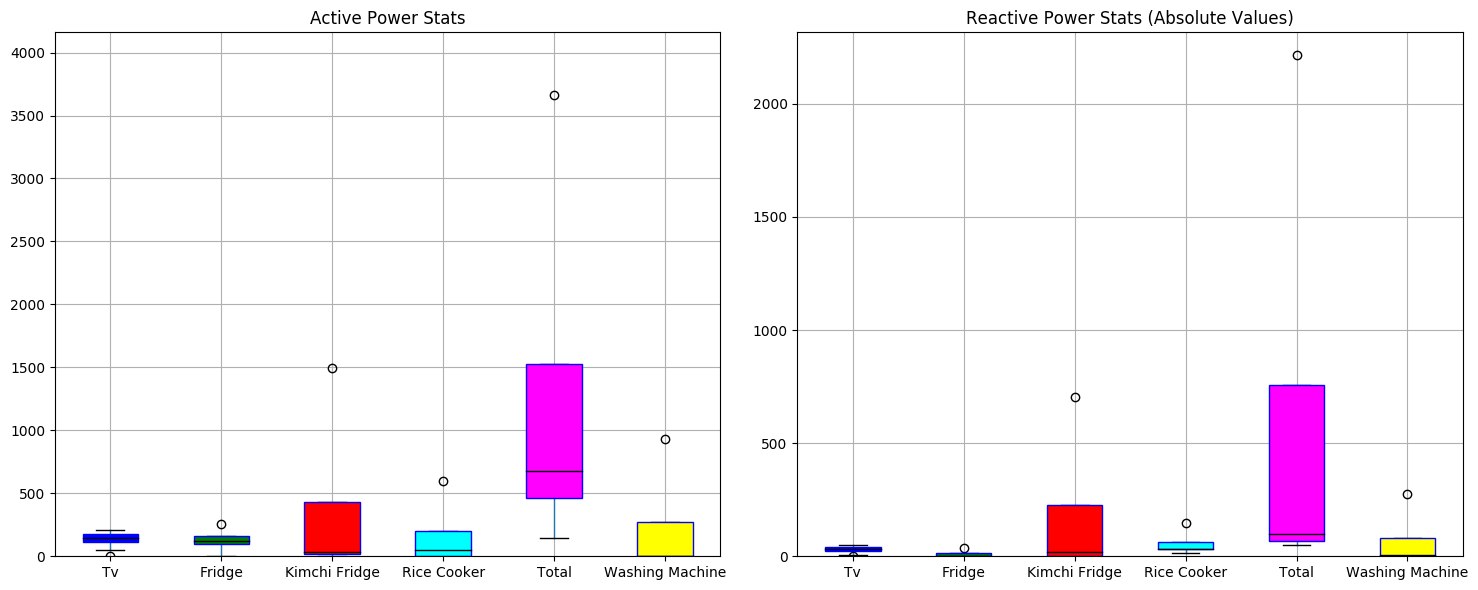

In [65]:
max_active = active_power_stats.iloc[7].max() + 500
max_reactive = reactive_power_stats.abs().iloc[7].max() + 100

cleaned_names_active = [clean_name(name) for name in active_power_stats.columns]
cleaned_names_reactive = [clean_name(name) for name in reactive_power_stats.columns]

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)  

active_power_stats.boxplot(patch_artist=True, boxprops=dict(facecolor='b', color='b'), medianprops=dict(color='black'))
for patch, color in zip(plt.gca().artists, colors):
    patch.set_facecolor(color)
plt.title('Active Power Stats')
plt.ylim(0, max_active)
plt.xticks(range(1, len(cleaned_names_active) + 1), cleaned_names_active)

plt.subplot(1, 2, 2)
reactive_power_stats.abs().boxplot(patch_artist=True, boxprops=dict(facecolor='b', color='b'), medianprops=dict(color='black'))
for patch, color in zip(plt.gca().artists, colors):
    patch.set_facecolor(color)
plt.title('Reactive Power Stats (Absolute Values)')
plt.ylim(0, max_reactive)
plt.xticks(range(1, len(cleaned_names_reactive) + 1), cleaned_names_reactive)

plt.tight_layout()
plt.show()

## Histograms for Active and Reactive Power per Appliance

In [63]:
plt.figure(figsize=(15, 10))
for i, appliance in enumerate(active_power_stats.columns):
    plt.subplot(3, 2, i+1) 

    appliance_data = day_data[day_data['appliance_name'] == appliance]
    plt.hist(appliance_data['active_power'], bins=20, alpha=0.7, color='green', label='Active Power')
    plt.hist(appliance_data['reactive_power'], bins=20, alpha=0.7, color='red', label='Reactive Power')
    
    app = clean_name(appliance)
    plt.title(f'{app} Power')
    plt.xlabel('Power (Watts)')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

## Measurements Gap Occurrence by Threshold and Appliance

In [55]:
def count_gaps(df, thresholds):
    gap_counts = {threshold: [] for threshold in thresholds}
    df['time_diff'] = df.index.to_series().diff().dt.total_seconds().fillna(0)
    
    for appliance in df['appliance_name'].unique():
        appliance_data = df[df['appliance_name'] == appliance]
        
        for threshold in thresholds:
            gap_count = np.sum(appliance_data['time_diff'] > threshold)
            gap_counts[threshold].append(gap_count)
   
    return gap_counts

## Heatmap

In [67]:
def plot_gap_occurrences(gap_counts, appliance_names):
    appliance_names = [clean_name(name) for name in appliance_names]
    heatmap_data = pd.DataFrame(gap_counts, index=appliance_names)
    heatmap_data = heatmap_data.T 
    epsilon = 1e-6
    heatmap_data += epsilon
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="viridis", norm=LogNorm())
    plt.title('Gap Occurrences for One Day by Appliance and Threshold')
    plt.ylabel('Threshold')
    plt.xlabel('Appliance Name')
    plt.xticks(rotation=45)
    plt.yticks(ticks=np.arange(len(heatmap_data.index)), labels=[format_threshold(th) for th in heatmap_data.index], rotation=0)
    plt.show()

In [68]:
thresholds = [14400, 7200, 3600, 1800, 900, 60, 30, 15, 1]
gap_counts = count_gaps(day_data, thresholds)
appliance_names = day_data['appliance_name'].unique()
plot_gap_occurrences(gap_counts, appliance_names)

## Data Aggregation

### By Hour

In [21]:
df=day_data.reset_index()
df_hour = aggregate_by_hour(df)
df_hour

active_power  reactive_power
hour appliance_name                               
0    TV                 161.271836      -35.932082
     fridge             125.161335       -4.018082
     kimchi-fridge       45.519875       30.391788
     rice-cooker         37.753397      -33.322667
     total              863.842655      -47.904978
...                            ...             ...
23   fridge             126.201566       -3.064715
     kimchi-fridge       42.206946       28.161348
     rice-cooker         36.818909      -33.690996
     total              595.988665      -62.443994
     washing-machine      0.068456        1.272801

[138 rows x 2 columns]

In [67]:
def get_days_agg_hour(base_path, start_date, end_date):
    all_days_agg = []
    start_date = datetime.strptime(start_date, "%Y%m%d")
    end_date = datetime.strptime(end_date, "%Y%m%d")

    for day_folder in sorted(os.listdir(base_path)):
        folder_date = datetime.strptime(day_folder, "%Y%m%d")
        if start_date <= folder_date <= end_date:
            day_path = os.path.join(base_path, day_folder)
            if os.path.isdir(day_path):
                day_data = get_one_day(day_path)
                day_data.reset_index(inplace=True)
                day_data_agg = aggregate_by_hour(day_data)
                all_days_agg.append(day_data_agg)
    return pd.concat(all_days_agg)

In [66]:
start_date = '20160910'
end_date = '20160917' 
days_agg_hour = get_days_agg_hour(house_path, start_date, end_date)

{'rice-cooker', 'fridge', 'washing-machine', 'total', 'kimchi-fridge'}
{'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'total', 'kimchi-fridge'}


### Barplots for Active Power per Appliance

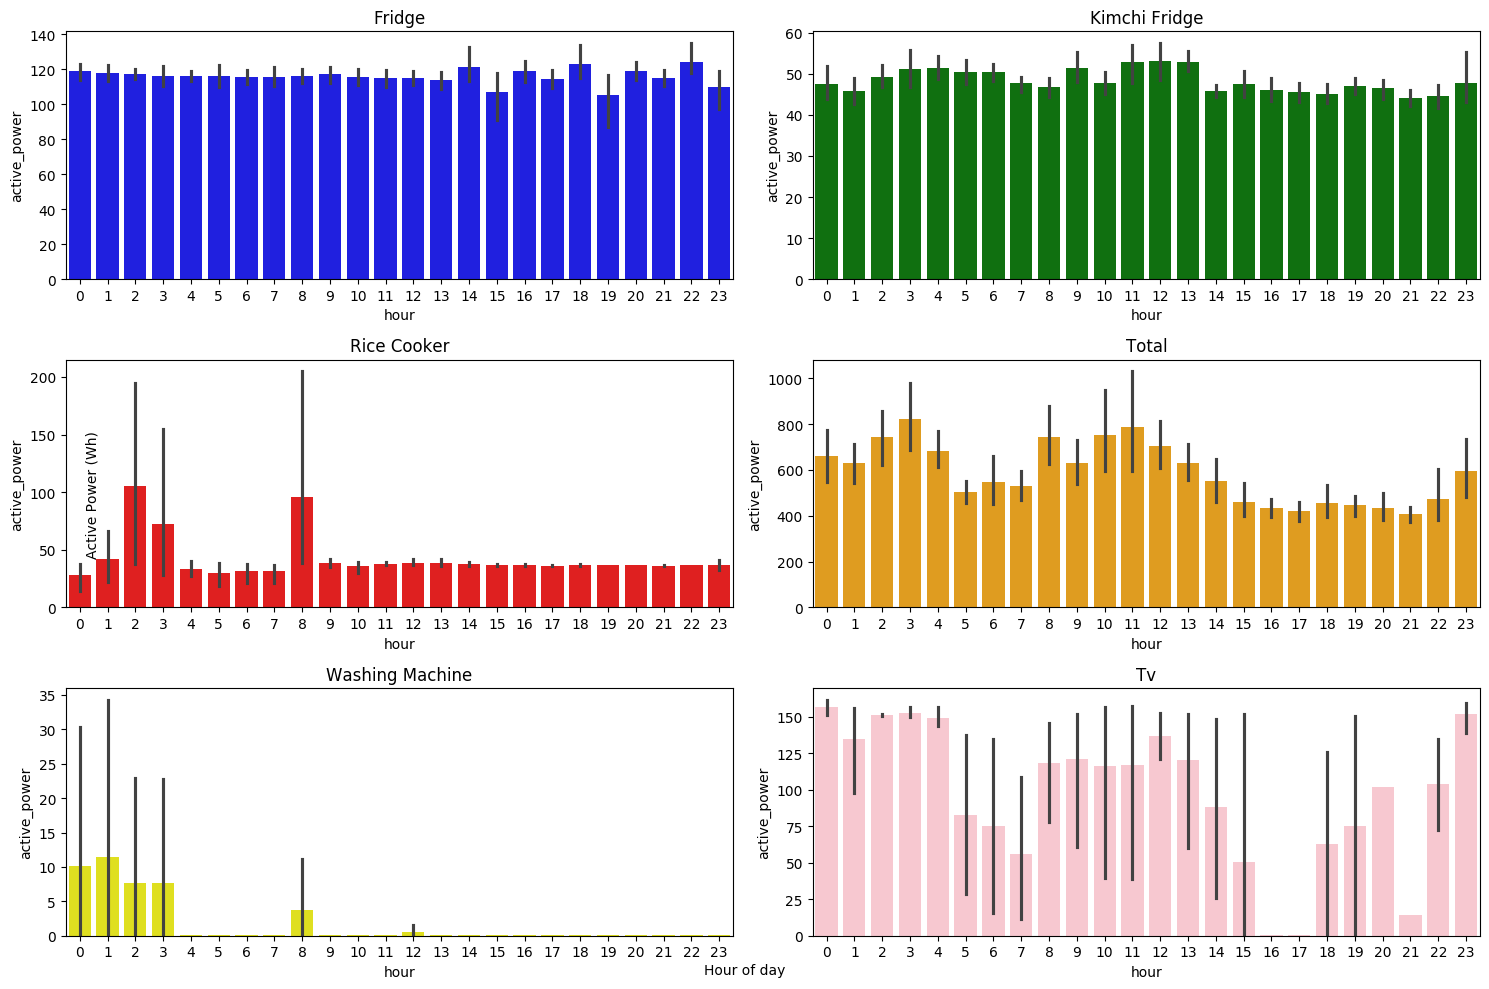

In [65]:
aggregated_data =days_agg_hour.reset_index()
appliances = aggregated_data['appliance_name'].unique()
colors = ['blue', 'green', 'red', 'orange', 'yellow', 'pink'] 
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()
for i, appliance in enumerate(appliances):
    appliance_data = aggregated_data[aggregated_data['appliance_name'] == appliance]
    cleaned_appliance_name = clean_name(appliance)
    sns.barplot(x='hour', y='active_power', data=appliance_data, ax=axes[i], color=colors[i])
    axes[i].set_title(cleaned_appliance_name)
    axes[i].set_xlabel('Hour of the Day')
    axes[i].set_ylabel('Average Active Power (Wh)')
plt.tight_layout()
plt.show()

### By Minute

In [82]:
def aggregate_by_minute(target_data):
    target_data['timestamp'] = pd.to_datetime(target_data['timestamp'], unit='ms')
    target_data['minute'] = target_data['timestamp'].dt.minute
    target_data_agg = target_data.groupby(['minute', 'appliance_name']).agg({'active_power': 'mean', 'reactive_power': 'mean'})
    return target_data_agg

In [83]:
from datetime import datetime
def get_days_agg_minute(base_path, start_date, end_date):
    all_days_agg = []
    start_date = datetime.strptime(start_date, "%Y%m%d")
    end_date = datetime.strptime(end_date, "%Y%m%d")

    for day_folder in sorted(os.listdir(base_path)):
        try:
            folder_date = datetime.strptime(day_folder, "%Y%m%d")
        except ValueError:
            continue
        if start_date <= folder_date <= end_date:
            day_path = os.path.join(base_path, day_folder)
            if os.path.isdir(day_path):
                day_data = get_one_day(day_path)
                day_data.reset_index(inplace=True)
                day_data_agg = aggregate_by_minute(day_data)
                all_days_agg.append(day_data_agg)
    return pd.concat(all_days_agg)
base_path = '../../files/ENERTALK/05' 
start_date = '20160910'
end_date = '20160917'
days_agg_minute = get_days_agg_minute(base_path, start_date, end_date)   

{'rice-cooker', 'fridge', 'washing-machine', 'total', 'kimchi-fridge'}
{'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'total', 'kimchi-fridge'}


In [84]:
days_agg_minute

active_power  reactive_power
minute appliance_name                               
0      fridge             104.622061       -4.077235
       kimchi-fridge       70.995280       54.312658
       rice-cooker         42.708081      -34.395392
       total              484.185106      -33.004549
       washing-machine      0.078805        1.265863
...                              ...             ...
59     fridge             123.958407       -4.568240
       kimchi-fridge       37.555515       24.834538
       rice-cooker         37.630223      -33.699983
       total              461.754153      -67.926144
       washing-machine      0.066915        1.286714

[2640 rows x 2 columns]

In [55]:
df=days_agg_minute.drop(columns=['reactive_power'])
df=df.reset_index()
concatenated_df = pd.DataFrame()
chunk_size = 60

for start in range(0, len(df), chunk_size):
    chunk = df.iloc[start:start + chunk_size]
    pivoted_chunk = chunk.pivot(index='minute', columns='appliance_name', values='active_power')
    concatenated_df = pd.concat([concatenated_df, pivoted_chunk])

concatenated_df = concatenated_df.reset_index(drop=True)

In [56]:
concatenated_df

appliance_name      fridge  kimchi-fridge  rice-cooker       total  \
0               104.622061      70.995280    42.708081  484.185106   
1                98.240536      63.145984    27.336924  460.094438   
2                96.058147      38.071028    49.469067  468.816412   
3                93.908941      36.859782    27.382801  473.269466   
4                95.495783      43.426003    48.562109  478.364760   
..                     ...            ...          ...         ...   
475             117.505205      42.326803    36.278810  489.800406   
476             120.081218      32.715337    33.536849  482.829756   
477             123.230345      62.832961    36.304985  513.518105   
478             123.629735      54.836369    31.625023  509.346341   
479             123.958407      37.555515    37.630223  461.754153   

appliance_name  washing-machine  TV  
0                      0.078805 NaN  
1                      0.077947 NaN  
2                      0.076869 NaN  
3                      0.077915 NaN  
4                      0.077200 NaN  
..                          ...  ..  
475                    0.066752 NaN  
476                    0.067274 NaN  
477                    0.067400 NaN  
478                    0.066715 NaN  
479                    0.066915 NaN  

[480 rows x 6 columns]

### Lineplot of Active Power per Appliance Over 7 Days 

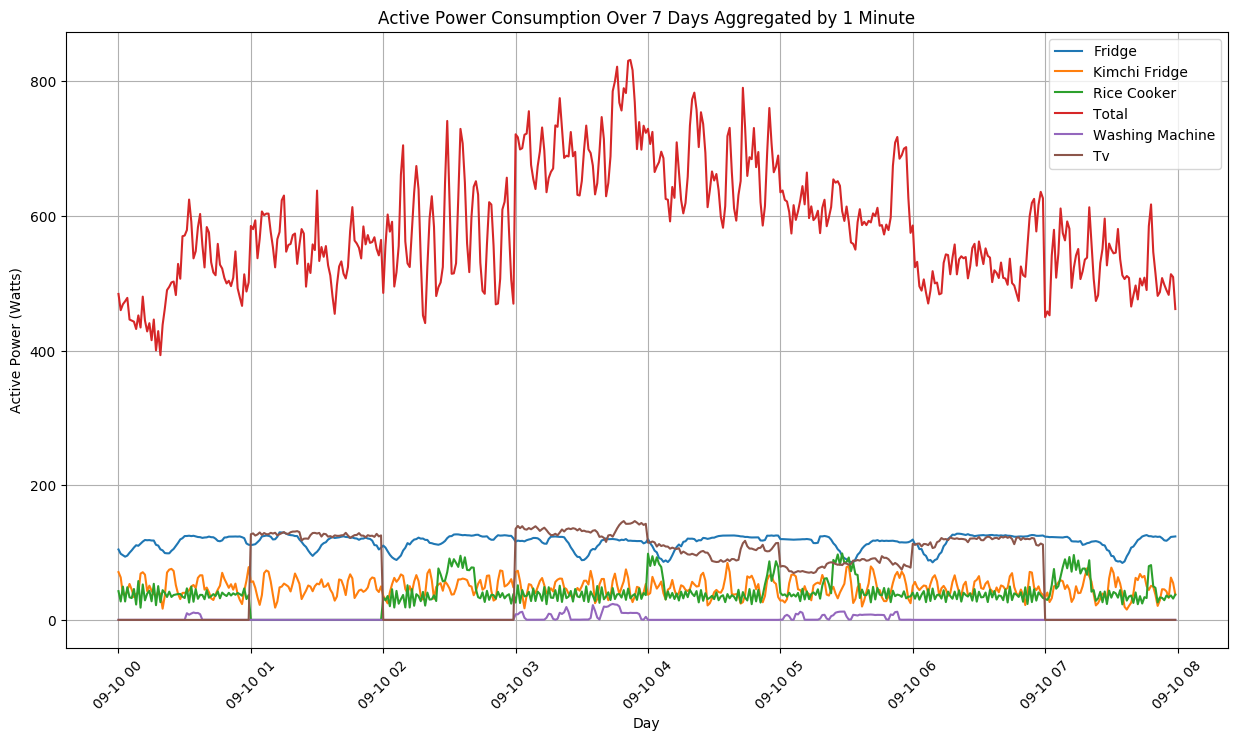

In [57]:
df=concatenated_df.fillna(0)
total_minutes = len(df)
date_range = pd.date_range(start='2016-09-10', periods=total_minutes, freq='T')
df.index = date_range
plt.figure(figsize=(15, 8))
for column in df.columns:
    label_app= clean_name(column)
    plt.plot(df.index.to_numpy(), df[column].to_numpy(), label=label_app)
plt.title('Active Power Consumption Over 7 Days Aggregated by 1 Minute')
plt.xlabel('Day')
plt.ylabel('Active Power (Watts)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Power Consumption Peak Hours 

In [46]:
start_date = '20160910'
end_date = '20160917' 
days_agg_hour = get_days_agg_hour(house_path, start_date, end_date)

{'rice-cooker', 'fridge', 'washing-machine', 'total', 'kimchi-fridge'}
{'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'TV', 'total', 'kimchi-fridge'}
{'rice-cooker', 'fridge', 'washing-machine', 'total', 'kimchi-fridge'}


In [42]:
days_agg_hour.drop(columns=['reactive_power'])

active_power
hour appliance_name               
0    fridge             119.906946
     kimchi-fridge       50.693031
     rice-cooker         38.615186
     total              637.323246
     washing-machine      0.091733
...                            ...
23   fridge             107.661611
     kimchi-fridge       42.207339
     rice-cooker         38.561530
     total              475.184962
     washing-machine      0.068175

[1025 rows x 1 columns]

In [47]:
days_agg_hour=days_agg_hour.reset_index()

## Peak Hours Heatmap

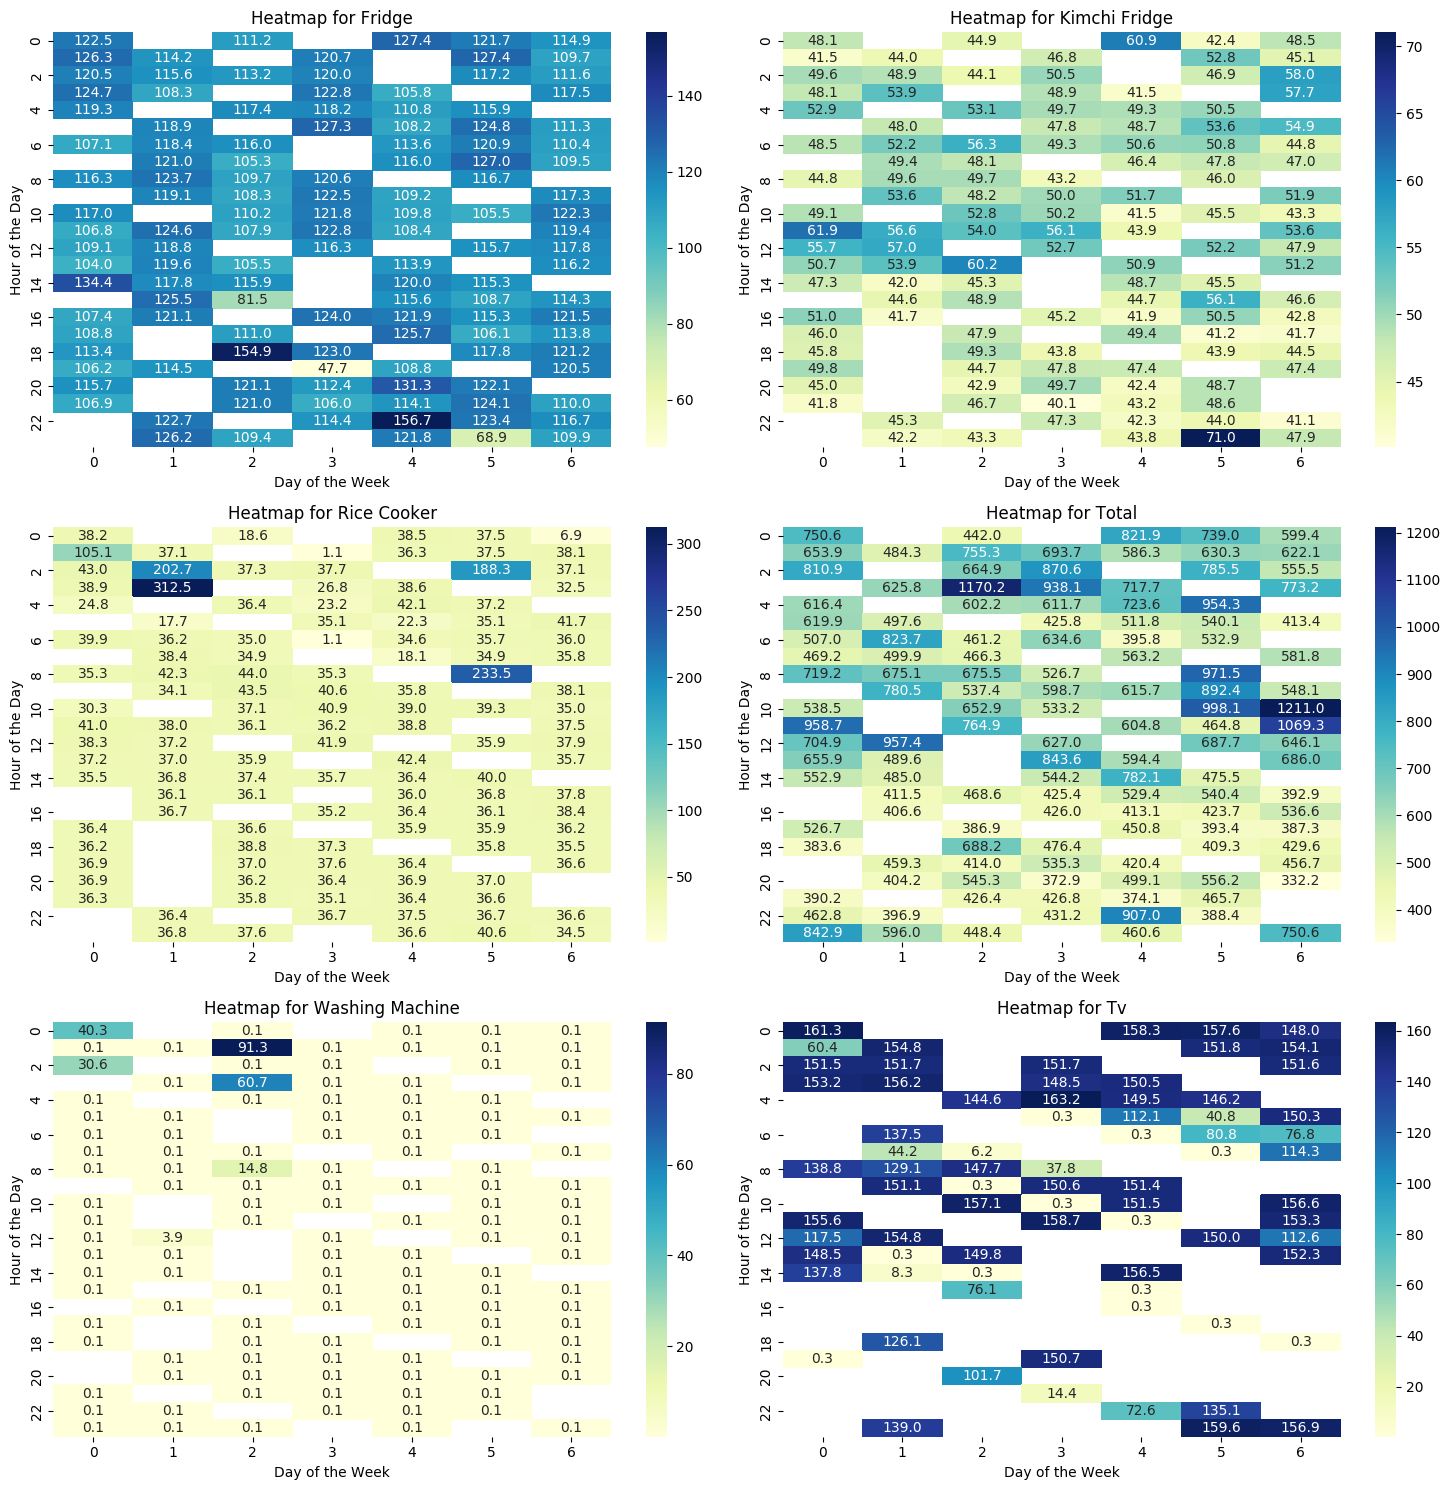

In [52]:
appliances = days_agg_hour['appliance_name'].unique()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for i, appliance in enumerate(appliances):
    appliance_data = days_agg_hour[days_agg_hour['appliance_name'] == appliance].copy()
    total_hours = appliance_data['hour'] + appliance_data.index // 24
    appliance_data['day_of_week'] = total_hours % 7
    heatmap_data = appliance_data.pivot_table(index='hour', columns='day_of_week', values='active_power')
    
    ax = axes[i]
    app=clean_name(appliance)
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".1f", ax=ax)
    ax.set_title(f'Heatmap for {app}')
    ax.set_xlabel('Day of the Week')
    ax.set_ylabel('Hour of the Day')

plt.tight_layout()
plt.show()